

a customer segmentation analysis and a customer life time value prediction. A customer segmentation analysis is crucial for business in order to identify and understand their customers needs and behaviors. If Olist wants to take direct actions in order to increase the revenue of customers then it needs to take different actions based on the different needs the customers might have. 

# Overview
This workbook consist of three parts; a discriptive analysis, a prediction of estimated delivery time (regression) and a prediction of late deliveries (classification).

This notebook got three purposes:
1. Explore the delivery data provided by Olist.
2. Improve the estimated delivery date given to customers at the purchase moment.
3. Predict whether a delivery is going to be late.

In [ ]:
#3. Use clustering (k-means) to sugest where and how many warehouses to construct

## KPI

TODO

# <font color='blue'>Setup 1</font>: Load Libraries

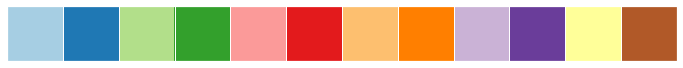

In [1]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random

%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# <font color='blue'>Setup 2</font>: Load data

The workbook will focus on the delivery and Geospatial part of the OLIST dataset. Therefore, the following datasets are loaded and joined:

- olist_customers_dataset
- olist_order_items_dataset
- olist_customers_dataset
- olist_sellers_dataset
- olist_geolocation_dataset

These are joined by the left-join operation and dataformat is set. 

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    file_path = os.path.join ('../data/') 
    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1")
    return df

In [3]:
# Reading the olist_orders tables
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
sellers = load_table('olist_sellers_dataset.csv')
geo = load_table('olist_geolocation_dataset.csv')

# Rename column names
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']

### Jensen kan måske forklare dette

In [4]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

In [5]:
# Removing outliers based on coordinates
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]
#source: https://www.kaggle.com/andresionek/geospatial-analysis-of-brazilian-e-commerce

# <font color='blue'>Setup 3</font>: Merge datasets and clean

Looking at the geolocations

In [6]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Since the zip-codes has several different geolocations very close to each other, we will aggregate those different locations into a mean location. explain.... 

In [7]:
geo = geo.groupby('geolocation_zip_code_prefix')['geolocation_lat','geolocation_lng'].agg('mean').reset_index()

Now that each zipcode has a unique geolocations, they are joined (left) on the customer and sellers dataset

In [8]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']

jensen forklar kort

In [9]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 'order_purchase_timestamp',
                         'order_approved_at','order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date','order_price',
                         'quantity','freight_value','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In this analysis only the orders with an order status of "delivered" are considered. As seen from the list below several different order statuses exist. 

In [10]:
print(list(set(orders_all.order_status)))
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

['unavailable', 'shipped', 'canceled', 'invoiced', 'created', 'processing', 'approved', 'delivered']


All the timestamp columns are changed to pandas datetime format

In [11]:
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

First the number of missing values (NaN) are counted for each column and then they are removed

In [12]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    print(num_missing)
          
count_missing_values(delivered_orders)
delivered_orders = delivered_orders.dropna()

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  14      0.0001
order_delivered_carrier_date        2      0.0000
shipping_limit_date                 0      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_price                         0      0.0000
quantity                            0      0.0000
freight_value                       0      0.0000
customer_lat                      274      0.0027
customer_lon                      274      0.0027
seller_lat                        222      0.0022
seller_lon                        222      0.0022


# <font color='blue'>Part 1</font>: Descriptive analysis

When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. While the customer is given a `order_estimated_delivery_date`.

In [13]:
#Calculating difference between order_estimated_delivery_date and the actual order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

In [14]:
delivered_orders['delivery_difference'].describe()

count    99678.000000
mean        10.987720
std         10.208975
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64

The product is recieved by the customer 10,98 days ahead of the estimated delivery day.

In [15]:
print("Number of orders delivered later than the estimated delivery data:",len(delivered_orders[delivered_orders['delivery_difference']<0]))

Number of orders delivered later than the estimated delivery data: 7943


Meaning ~8% of the orders was delivered later than the estimated delivery date.

In the olist_orders_dataset we have 95978 unique orders. I.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether we are to blame the sellers or the logistic firm for the orders delivered late. Therefor we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If Y > 0 the order was delivered on time. 
- If Y < 0 and X > 0 the logistic firm is the one to blame
- If Y < 0 and X >= Y then the seller is the one to blame
- If Y < 0 and X < 0 the both the seller and the logistic firm is to blame

In [16]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

In [17]:
# Removing outlier
delivered_orders = delivered_orders.drop(89664)
delivered_orders['shipping_difference'].describe()

count    99677.000000
mean         2.832569
std          3.747486
min       -117.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        175.000000
Name: shipping_difference, dtype: float64

A product is passed on to the logistic firm 2.8 days ahead on average.

In [18]:
def plot_late_order(df):
    X = [x for x in df.delivery_difference]
    X = np.array(X)
    Y = [y for y in df.shipping_difference]
    Y = np.array(Y)

    col = np.where((X<0) & (Y<0) & (Y<X),'red',
            np.where((X<0) & (Y<0) & (Y>=X),'yellow',
                np.where((X<0) & (Y>=0),'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Delivery difference')
    ax.set_ylabel('Shipping difference')
    ax.set_title('Orders')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

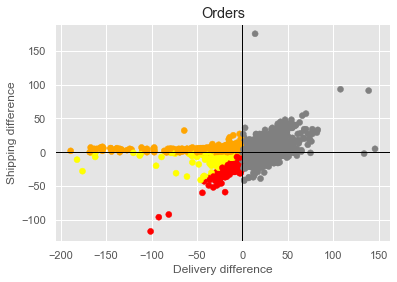

In [19]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

In [20]:
X = [x for x in delivered_orders.delivery_difference]
Y = [y for y in delivered_orders.shipping_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]>=0)]
yellow_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]>=X[i])]
red_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]<X[i])]

In [21]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 92.03 pct. of the orders was delivered on time
  5.78 pct. of the orders was delivered late because of the logistic firm
  1.34 pct. of the orders was delivered late because of the seller
  0.85 pct. of the orders was delivered late because of both the seller and logistic firm


# <font color='blue'>Part 2</font>: Prediction - Estimated delivery time

In [22]:
delivered_orders['actual'] = delivered_orders.order_delivered_customer_date - delivered_orders.order_purchase_timestamp
delivered_orders['actual'] = delivered_orders['actual'].dt.days

In [ ]:
delivered_orders.actual.describe()

# -------adding features--------

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def geoDistance(lat0, lon0, lat1, lon1):
    # Approx. radius of earth (km)
    R = 6373.0 
    # Convert to radians
    lat0, lon0 = radians(lat0), radians(lon0)
    lat1, lon1 = radians(lat1), radians(lon1)
    
    # Getting differences
    dlon, dlat = lon1 - lon0, lat1 - lat0
    
    # Use haversine formula
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
delivered_orders['Distance'] = delivered_orders.apply(lambda row:\
    geoDistance(row['customer_lat'], row['customer_lon'], row['seller_lat'], row['seller_lon']), axis=1)

In [ ]:
#https://www.weatherbit.io/api/weather-history-hourly

# -------adding features end--------

- take a look at what the actual delivery - the forecasted delivery was (have this as an error measure
- the forecast should be trained from the actual delivery time, and have this as the ideal model. If we can forecast exactly how much time it takes. 
- 

In [ ]:
from sklearn.model_selection import train_test_split

features = ['order_price','quantity','freight_value','customer_lat',
           'customer_lon','seller_lat','seller_lon','Distance']
target = ['actual']

X = np.array(delivered_orders[features])
y = np.array(delivered_orders['actual'])
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

# <font color='blue'>2.2</font>: Establish baseline

In [ ]:
x = delivered_orders.actual
sns.distplot(x,bins=100);

In [ ]:
estimated_delivery = delivered_orders.order_estimated_delivery_date-delivered_orders.order_purchase_timestamp
estimated_delivery = estimated_delivery.dt.total_seconds() / (24 * 60 * 60)
sns.distplot(estimated_delivery,bins=100);

In [ ]:
bins = np.linspace(-10, 10, 100)

plt.hist(x, bins, alpha=0.5, label='x')
plt.hist(estimated_delivery, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

##### Baseline model

Predicting the average delivery time for all the orders

In [ ]:
#Creating a baseline predicting the average delivery time
baseline_preds = delivered_orders['actual'].values
X_baseline = baseline_preds[:len(X_train)]
Y_baseline = baseline_preds[len(X_train):]

Y_baseline = np.mean(Y_baseline)
baseline_errors = np.sqrt(((Y_baseline - y_test) ** 2).mean())
print('Baseline RMSE error:', round(np.mean(baseline_errors), 2), 'days')

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train);

In [ ]:
predictions = lr.predict(X_test)
errors = np.sqrt(((predictions - y_test) ** 2).mean())
print('RMSE for linear regression model: ', round(np.mean(errors), 2), 'days')

We see that this model performs slightly better. However, we could perform better on this prediction 

# Jens-------------

Spørg jensen:
- nedenstående tager laver en y_baseline, der er lige så lang som y_train. Men denne Y_baseline består af tallene fra "delivery difference" - dette skal vel være actual, når vi prøver at forudsige den faktiske delivery dato. 

In [ ]:
baseline_preds = delivered_orders['delivery_difference'].values
X_baseline = baseline_preds[:69774]
Y_baseline = baseline_preds[69774:]

baseline_errors = abs(Y_baseline - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'days')

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
predictions = lr.predict(X_test)
errors = abs(predictions - y_test)
print('Average baseline error: ', round(np.mean(errors), 2), 'days')

In [ ]:
mape = 100 * (errors/y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

In [ ]:
errors

In [ ]:
mape

# Jens-------------

# <font color='blue'>Part 3</font>: Prediction - Late delivery (classification)

This last analysis will seek to predict whether a delivery will be late or not. An online retailer platform like Olist can benefit from this analysis in several different ways: First, simply knowing which factors affect the delivery of orders is useful. Secondly, having this model deployed Olist would be able to warn sellers and customers when a order was predicted to be delivered late. 

his parameter setting means that the penalties for false predictions in the loss function will be weighted with inverse proportions to the frequencies of the classes. This can solve the problem you describe

This model will use logistic regression to perfrom the binary classification, where the the target variable $y$ is defined as: 1 if the order was delivered on time and 0 if it was late. T

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

X = delivered_orders[['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']]
X = preprocessing.StandardScaler().fit_transform(X)

y = (delivered_orders.order_estimated_delivery_date > delivered_orders.order_delivered_customer_date).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
y.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial', class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
name = ['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']
coef = clf.coef_[0]

In [ ]:
list(zip(name,coef))

Interpretation of coefficients: 
- Orders with larger quantity are more likely to be delivered on time. 
- Orders with longer distance between seller and customer are less likely to be delivered on time.
- Orders with a high customer longitude coordinate are less likely to be delivered on time.
close to coast 

Features that could prove useful to this model, but has not yet been implemented:
- Weather forcast data
- Historical weather data
- Real distance between seller and customer (on roads)
- Seller track record (in terms of number of previously late deliveries. 
- Seller reviews (average)


- Previously late delivery

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
from pysal.viz.splot import mapping as maps

In [ ]:
delivered_orders['late'] = y

late_orders = delivered_orders[delivered_orders.late == 0]
df = late_orders[['customer_lat','customer_lon']]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.customer_lon, df.customer_lat))

orders = delivered_orders[delivered_orders.late == 1]
df1 = orders[['customer_lat','customer_lon']]
gdf1 = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.customer_lon, df1.customer_lat))

In [ ]:
delivered_orders.groupby(['customer_lat','customer_lon']).agg({'late':'sum', 'customer_lat':'count'})

In [ ]:
# define color dictionary
color_map = {1:"blue", 0:'red'}

In [ ]:
plt.rcParams['figure.figsize'] = [14, 6]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# restrict to South America.
ax1 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

ax2 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')


colors_late = [color_map[x] for x in late_orders['late']]
gdf.plot(ax=ax1, color=colors_late, alpha=0.3, markersize=.1)

colors = [color_map[x] for x in orders['late']]
gdf1.plot(ax=ax2, color=colors, alpha=0.1, markersize=.1)
plt.show()
